# Practical 10: Social Media Mining

## In this practical
1. [Registering Twitter app and getting a token](#register)
2. [Importing data from Twitter](#import)
3. [Creating word clouds](#wordclouds)
4. [Topic modelling](#LDA)
5. [Graph analysis](#graph)
6. [Community detection](#community)

---
**Written by Hendi Lie (h2.lie@qut.edu.au), Richi Nayak (r.nayak@qut.edu.au) and Taufik Sutanto. All rights reserved.**

This practical introduces you to social media mining using Python. The material covered in this practical will be identical to the slides for SAS users, with addition of detailed code and library usage.

Social media analysis is a process of gathering data from stakeholder conversations on digital media and processing it into structured insights, leading to more information-driven business decisions and increased customer centrality for brands and businesses. With the growing importance of social media usage for many industries, social media analysis has become a highly sought skill in data science.

There are 7 steps in mining business insights from social media:
1. **Identification**: finding a suitable source of information for analytical purposes.
2. **Extraction**: process of getting data from the social media. This process is commonly done through API calls, crawling or scraping.
3. **Cleaning**: Social media data is highly noisy. Preprocessing them into clean data is necessary.
4. **Analysing**: Applying analysis techniques like centrality analysis, community detection, etc.
5. **Visualisation**: presenting data in form of graph or plot.
6. **Interpretation or consumption**: interpreting analysis results for decision making process.

In this practical, we will be applying 4 data mining techniques (centrality analysis, community detection, topic modelling and cluster labelling) to data crawled from Twitter.

Before you start this practical, please ensure you have all required libraries (Twython, NetworkX, json (is default in Python standard library), community, tqdm, Wordcloud, scipy, numpy and NLTK). Run the following commands to install all of them.

`pip install Twython NetworkX tqdm Wordcloud scipy numpy nltk python-louvain`

## 1. Registering Twitter app and getting access tokens

We will be using Twitter data in this practical. To access Twitter data legally, you will have to register for a Twitter account, create a Twitter app and get the access key, access secret, consumer key, and consumer secret to access the Twitter API. Step by step instructions on how to register is shown in the slides. Please keep all of your keys secret. After you get all required keys, add them into a text file (e.g. `MyApiKeys.txt`) in format of:
**consumer_key,consumer_secret,access_token,access_secret**

Once your API keys file is ready, create a Twython connection to the API using the following code.

In [1]:
from twython import Twython

# create a helper function to connect to Twitter API using Twython
def connect(keyFile = 'MyApiKeys.txt'):
    try:
        keys = open(keyFile,encoding='utf-8', errors ='ignore', mode='r').read().strip()
        c_key,c_secret,acc_key,acc_secret = keys.split(',')
        twitter = Twython(c_key,c_secret,acc_key,acc_secret)
        user = twitter.verify_credentials()
        print('Welcome {}, you are now connected to twitter server'.format(user['name']))
        return twitter
    except:
        print("Connection failed, please check your API keys and don't add extra line(s) in 'MyApiKeys.txt'")
        
# try to connect
twitter = connect()

Welcome Hendi Lie, you are now connected to twitter server


We are now ready to crawl Twitter for social media data.

## 2. Importing data from Twitter

There are multiple ways to import data from a social media such as Twitter. Some examples including **searching** using a specific query, **streaming** ( listening to feed of Twitter tweets) and scraping an user **timeline**.

In this practical, we will import data through **searching** on topic "data mining" using the Twython connection we have created earlier. You can change this topic according to your need.

**Please review and follow limitations set by Twitter's Term of Service and API limitations. IFN645 teaching staffs are not responsible for any actions you perform through your API key**

In the following cell, we will define two functions. `cleanUp` will take text extracted from a tweet and remove common noises found in tweet data. `getTweets` will search Twitter for N tweets matching a query and (optionally) clean them. Comments are provided to allow you understand content of both functions.

In [2]:
# import required libraries
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re


# create a tokenizer object and custom stopwords for Twitter
tokenizer=RegexpTokenizer(r'\w+')
stop = set(stopwords.words('english'));
stop.update(['http', 'https', 'rt', 'co', 'com', 'amp'])

# helper function - check if a string is consisted of all ascii characters
def isascii(s):
    return len(s) == len(s.encode())


def cleanUp(txt, stop=stop, tokenizer=tokenizer):
    # return cleaned text given stopwords and tokenizer object
    # critical steps are numbered
    
    # 0. define storage for clean sentence
    clean_sentences = []
    
    # 1. lowercase
    clean_txt = txt.lower()

    # 2. split the text into individual sentences
    sentenceS = clean_txt.replace('.',',,,,,').split(',,,,,')

    for sentence in sentenceS:
        clean_phrases = []

        # 3. split a sentence into phrases
        phraseS = sentence.replace(',',',,,,,').split(',,,,,')

        for phrase in phraseS:
            # 4. remove noisy characters (a), stopwords (b) and non-asci tokens (c)
            # using regex and tokenizers
            cleanWords = re.sub(r'[^\w]',' ', phrase)  #(a)
            cleanWords = tokenizer.tokenize(cleanWords) #(b)
            cleanWords = [w for w in cleanWords if w not in stop and isascii(w)] #(c)

            # 5. filter out terms with length < 1 and digit in it
            termS = [term for term in cleanWords if len(term) > 1 and not any(char.isdigit() for char in term)]

            # 6. add filtered terms into clean phrases
            if len(termS) >= 1:
                clean_phrases.append(' '.join(termS))

        # 7. add cleaned phrases into cleaned sentences
        clean_sentences.append(', '.join(clean_phrases))

    # 8. return cleaned text
    clean_txt = '. '.join(clean_sentences)
    return clean_txt


def getTweets(twitter, topic, N = 200, lan = 'en', clean=False):
    # search Twitter for a specific topic
    # parameter: twitter (a Twython connection), topic to search, N tweets to return, language, and whether to clean tweets
    
    # Tweets: list of all Tweets to return
    # MAX_ATTEMPTS: maximum number of requests that we will do for a topic
    # next_max_id = a Tweet ID to get the next page from the Twitter search function
    Tweets, MAX_ATTEMPTS, next_max_id = [], 99, 0
    
    for i in range(MAX_ATTEMPTS):
        if len(Tweets) >= N:
            print("Finished importing {}".format(len(Tweets)))
            break
            
        # first request
        if i == 0:
            results=twitter.search(q=topic, lang=lan, count=N)
        else:
            # subsequent requests
            try:
                results=twitter.search(q=topic,include_entities='true',max_id=next_max_id, lang=lan, count=N)
                
                # if successful, try to get the next max ID
                try:
                    next_results_url_params=results['search_metadata']['next_results']
                    next_max_id=next_results_url_params.split('max_id=')[1].split('&')[0]
                except:
                    print('Finished, no more tweets available for topic "%s"' %topic, flush = True);
                    break
            except:
                continue
        
        # add returned tweets to Tweets list
        for data in results['statuses']:
            if clean:
                data['text'] = cleanUp(data['text'])
            Tweets.append(data)
            
            if len(Tweets) >= N:
                break
    
    # finish
    return Tweets

Run the `getTweets` function to get tweets related to *data mining*. Set the `clean` parameter is set to False to run no cleaning. Each tweet returned will be in the format of a dictionary.

In [3]:
# run getTweets
topic = 'data mining'
Tweets = getTweets(twitter, topic)

# show the first tweet's user's screen name, created at and text property
tweet = Tweets[0]
print("Tweet by {} at {}, tweet: {}".format(tweet['user']['screen_name'], tweet['created_at'], tweet['text']))

Finished importing 200
Tweet by Pedra999 at Sun May 13 13:35:05 +0000 2018, tweet: RT @FinnTechFwd: Facebook to create its own cryptocurrency? | #Crypto #Cryptocurrency #Bitcoin #Ripple #Ethereum #ICO #Blockchain #AI #IoT…


To avoid parsing the Tweets redundantly, we can save the content of these Tweets into a file. Use the following functions. Each function should be quite straight forward.

In [4]:
import json

def saveTweets(Tweets,file='Tweets.json', plain = False): #in Json Format
    with open(file, 'w') as f:
        for T in Tweets:
            if plain:
                f.write(T+'\n')
            else:
                try:
                    f.write(json.dumps(T)+'\n')
                except:
                    pass

def loadTweets(file='Tweets.json'):
    f=open(file,encoding='utf-8', errors ='ignore', mode='r')
    T=f.readlines()
    f.close()
    
    for i,t in enumerate(T):
        T[i] = json.loads(t.strip())
    return T

## 3. Creating word clouds

A commmon method to view large amount of social media data is to create **word cloud**. A word cloud will show all frequent words/terms in a set of text data. More frequent words will have larger font size. We can create a word cloud from the Tweets we just parsed using `WordCloud` library in Python. Define a helper function as below:

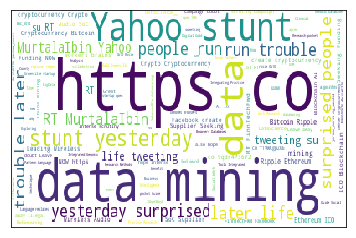

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def wordClouds(Tweets, file = 'wordCloud.png'):
    # create a wordcloud from list of Tweets and save it to file
    
    # extract text from Tweets
    txt = [t['text'] for t in Tweets];
    txt = ' '.join(txt)
    
    # create a WordCloud
    wc = WordCloud(background_color="white")
    wordcloud = wc.generate(txt)
    
    # plot it using matplotlib
    plt.figure(num=1, facecolor='w', edgecolor='k')
    plt.imshow(wordcloud, cmap=plt.cm.jet, interpolation='nearest', aspect='auto'); plt.xticks(()); plt.yticks(())
    plt.savefig('wordCloud.png',bbox_inches='tight', pad_inches = 0.1, dpi=300)
    plt.show()
    
    # save it to file
    wc.to_file(file)
    
# run the above function
wordClouds(Tweets)

You should notice that this word cloud has many noises/stop words (e.g. https, RT, etc). It indicates that we have to perform preprocessing to clean the data. Re-run the `getTweets` function, this time with `clean` parameter set to `True`.

Finished importing 200


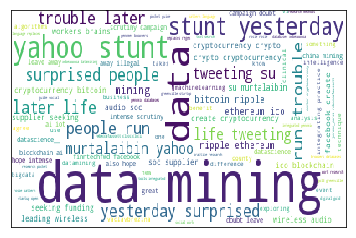

In [6]:
Tweets = getTweets(twitter, topic, clean=True)
wordClouds(Tweets)

The produced word cloud should show much more meaningful terms and results.

## 4. Topic modelling

Another common method to explore various information within a social media data is via topic modelling, such as Latent Dirichlet Allocation (LDA). LDA is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's creation is attributable to one of the document's topics.

More details about LDA can be found in this [paper](http://www.cs.columbia.edu/~blei/papers/BleiNgJordan2003.pdf![image.png](attachment:image.png)

In this practical, we will try to display the top 10 most popular topics from our tweet data. Follow the code below.

Note that the LDA is computationally expensive and require a significant amount of computer’s memory. Therefore, only use this command if your Tweets is not large (~ < 50,000). Otherwise, it is more efficient to do a topic modelling on clusters/communities as we are going to discuss latter!

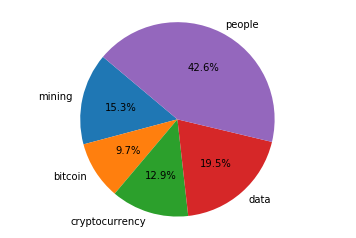

In [7]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
import warnings, numpy as np

def getTopics(Tweets, dCom=None, topic=None, nTopics = 10, file = 'Topics_PieChart.png', tweetTopics=False):
    try:
        plt.clf(); plt.cla(); plt.close()
    except:
        pass
    if tweetTopics:
        txt = [cleanUp(t['text'], stop=stop, tokenizer=tokenizer) for t in Tweets]
    else:
        for t in topic.split()+[topic.replace(' ','')]:
            stop.add(t)
        txt = [cleanUp(t['text'], stop=stop, tokenizer=tokenizer) for t in Tweets if t['user']['screen_name'] in dCom[2]]
    saveTweets(txt,file='Cluster_Text.txt', plain = True)
    vectorizer = CountVectorizer(strip_accents = 'unicode',stop_words = 'english',lowercase = True,token_pattern = r'\b[a-zA-Z]{3,}\b',max_df = 0.95, min_df = 2)
    vsmTf = vectorizer.fit_transform(txt)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        lda_tf = LDA(n_topics=nTopics, random_state=0).fit(vsmTf)
    topics = lda_tf.components_
    docTopic =  [a.argmax() for a in topics]
    docTopic_Score =  [max(a) for a in topics]
    words = {y:x for x,y in vectorizer.vocabulary_.items()}
    docWords = [words[a] for a in docTopic]
    meanTopicsScores = {}
    for x,y in zip(docWords,docTopic_Score):
        if x in meanTopicsScores.keys():
            meanTopicsScores[x].append(y)
        else:
            meanTopicsScores[x] = [y]
    meanTopicsScores = {x:np.mean(y) for x,y in meanTopicsScores.items()}
    distinct_topics = list(set([words[t] for t in docTopic]))
    distinct_scores = [meanTopicsScores[t] for t in distinct_topics]
    distinct_scores = list(distinct_scores/max(distinct_scores))
    plt.pie(distinct_scores, labels=distinct_topics, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.savefig(file)
    plt.show()
    
    
getTopics(Tweets, tweetTopics=True)


## 5. Graph analysis

Given a set of points (vertices/nodes) and connections between them (edges), we can represent them as a graph (like image below).

![image](http://www.cpmponline.org/parentresource/images/c1u4sumgraph1.jpg)
 
In analysing social media data, we can represent each user as vertex and interactions between them(e.g. follow, reply, share) as edges. Given the Tweets we parsed from Twitter, we can build a social media network graph based on users' mention. We will use `networkx` library and function as below.

Please wait, building Graph .... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 132962.56it/s]


Finished. There are 136 nodes and 102 edges in the Graph


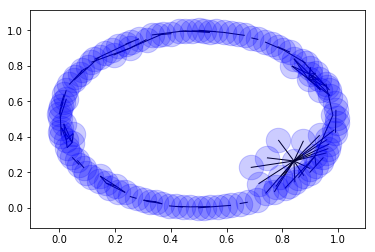

In [8]:
import networkx as nx
from tqdm import tqdm
# build a graph from users in parsed Tweets
def buildGraph(Tweets):
    print("Please wait, building Graph .... ")
    
    # initialise graph
    G = nx.Graph()
    for status in tqdm(Tweets):
        try:
            # add node to the graph
            usr=status["user"]["screen_name"]
            G.add_node(usr)
            
            mentions=status["entities"]["user_mentions"]
            for mention in mentions:
                usr_mention=mention["screen_name"]
                G.add_edge(usr,usr_mention)
        except:
            pass
        
    Nn=G.number_of_nodes()
    Ne=G.number_of_edges()
    print('Finished. There are {} nodes and {} edges in the Graph'.format(Nn, Ne))
    
    return G

# draw the networkx graph using pyplot
def drawGraph(G, file ='graph.png',labels=False, gType = 'spring'):
    # firstly, close any open plots
    try:
        plt.clf(); plt.cla(); plt.close()
    except:
        pass
    
    # draw graph using either one of 3 layouts
    if gType == 'spring':
        pos = nx.spring_layout(G)
    elif gType == 'shell':
        pos = nx.shell_layout(G)
    else:
        pos = nx.spectral_layout(G)
        
    # draw the graph
    nx.draw_networkx_nodes(G,pos, alpha=0.2,node_color='blue',node_size=600)
    if labels:
        nx.draw_networkx_labels(G,pos) # ,font_size=12,font_color='black'
    nx.draw_networkx_edges(G,pos) # width=4,alpha=0.1, ,edge_color='blue'
    
    # save the plot to a file
    plt.savefig(file)
    plt.show()
    
G = buildGraph(Tweets)
drawGraph(G)

You should see a ring consisted of blue circles (i.e. nodes) and blue lines connecting some of the nodes (i.e. edges). While this graph shows all users and interactions between them, further analysis is required to get a meaningful insight out of the graph.

### 5.1. Centrality Analysis

A method commonly applied to social media graph is centrality analysis. Centrality analysis identifies the most important vertices (i.e. social media users) within the graph. Finding these important users can allow you to focus analysing a key small subset of the graph. There are many metric to define importance of a user, but here we will find them based on `degree` or the number of edges connected to the node. Since the data is taken from Twitter, the edges are number of mentions. Users that are mentioned more frequenty are considered as important users.

Use the code below to perform centrality analysis on the graph.

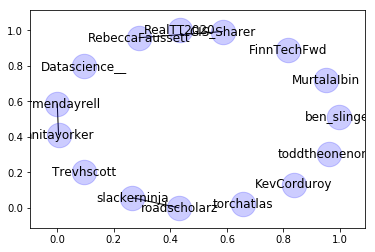

In [9]:
import community

def centrality(G, Nimportant=5, method='degree'):
    """ returns a subgraph of G with the most important nodes according to the centrality algorithm chosen """
    if method == 'eigenvector':
        ranking = nx.eigenvector_centrality_numpy(G)
    elif method == 'degree':
        dn = nx.degree(G)
        degs = [dn[u] for u in dn.keys()]; degs.sort(); degs = degs[::-1]; degs = degs[:Nimportant]
        important_nodes = [u for u in dn.keys() if dn[u] in degs]
        Gt=G.subgraph(important_nodes)
        important_nodes = [(u,dn[u]) for u in dn.keys() if dn[u] in degs]
    else:
        phi = (1+math.sqrt(5))/2.0 # largest eigenvalue of adj matrix
        ranking = nx.katz_centrality_numpy(G,1/phi)
    if method != 'degree':
        important_nodes = sorted(ranking.items(), key=operator.itemgetter(1))[::-1][0:Nimportant]
        dnodes=[n[0] for n in important_nodes]
        Gt = G.subgraph(dnodes)
    with open('Centrality_details.txt','w') as f:
        for var in important_nodes:
            f.write('%s\t %.3f\n' %(var[0],var[1]))
    
    return Gt
            
# find the 10 most important users in the graph
Gt = centrality(G, Nimportant=10, method='degree')
drawGraph(Gt, labels=True)

With centrality analysis, you have identified the top 5 important users in your social media graph.

## 6. Community detection

In addition to centrality analysis, a social media network can also be analysed by finding communities inside it. A network is said to have **community structure** if the nodes of the network can easily be grouped into a set of nodes where each node is densely connected internally. Another indicator of communities in a graph is **high modularity**, where nodes within modules have dense connections and nodes between modules have sparse connections.

In this practical, we will use Thomas Aynaud's community module. The following function will find the best partitions (communities) from a network graph `G`. Each community will be drawn using different colors. The function will also produce centrality details and save them as `community_details.txt` in the Notebook's folder.

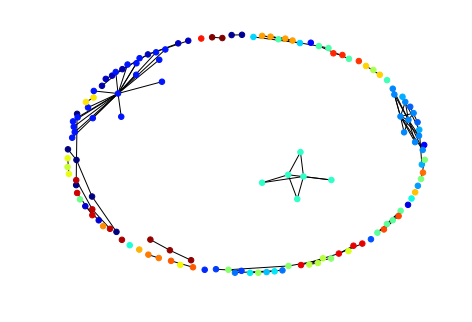

Number of Communities = 55
Network modularity = 0.92


In [10]:
''' Find communities in a social media graph G '''
def communities(G):
    # close all plots where possible
    try:
        plt.clf(); plt.cla(); plt.close()
    except:
        pass
    
    # find best partition
    part = community.best_partition(G)
    values = [part.get(node) for node in G.nodes()]  # get labels
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        nx.draw_spring(G, cmap = plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)
        plt.savefig('Communities.png')
        plt.show()
    
    # measure number of communities and network modularity
    mod, k = community.modularity(part,G), len(set(part.values()))
    print("Number of Communities = %d\nNetwork modularity = %.2f" %(k,mod)) # https://en.wikipedia.org/wiki/Modularity_%28networks%29
    
    # get members of each partition
    part_members, part_len, dCommunity = {}, {}, []
    for usr,par in part.items():
        if par not in part_members.keys():
            part_members[par]=[usr]; part_len[par]=1
        else:
            part_members[par]=part_members[par]+[usr]; part_len[par]+=1
    
    # save community details into text file
    with open('Community_details.txt','w') as f:
        for com in part_len:
            dCommunity.append((com, part_len[com], set(part_members[com])))
            f.write('community %d\t N=%d\t users= ' %(com,part_len[com]))
            f.write('%s\n' %(' '.join(part_members[com])))
    
    dCommunity.sort(key=lambda tup: tup[1])
    return dCommunity[::-1]

com = communities(G)

By finding communities within this network graph, we could narrow down our analysis within each community. In this section, we will use LDA that we introduced earlier to summarise topics found within the first two largest communities. Simply run the `getTopics` function as follows. Note that LDA require a sufficient amount of data too, it will fail to produce if the community is too small.

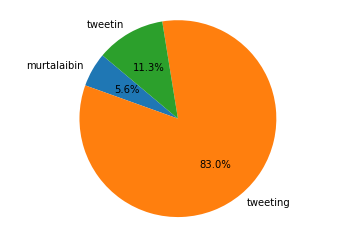

ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

In [11]:
# run LDA to summarise the first two communities
getTopics(Tweets, com[0], topic, nTopics=10, file = 'Topics_1st.png')  # first
getTopics(Tweets, com[1], topic, nTopics=10, file = 'Topics_2nd.png')  # second

An error occurs during running the second LDA, which indicates insufficient documents in the community.